# Random Forest for Ic Prediction

This notebook demonstrates how to use a Random Forest model to predict the Soil Behavior Type Index (Ic) from CPT data. It serves as a classical machine learning baseline for comparison with deep learning models.

---

## 1. Import Required Libraries
Import libraries such as pandas, numpy, scikit-learn, and matplotlib.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os
import yaml

# Change working directory to project root
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

# Add src to path
import sys
sys.path.append(os.path.abspath('src'))

## 2. Load and Explore Dataset

Load the dataset containing Ic and relevant features. Display basic statistics and visualize feature distributions.

In [ ]:
# Load the raw data path from the fine-tuning config
with open('configs/PG_finetune_Ic.yaml', 'r') as f:
    config = yaml.safe_load(f)
data_path = config['data_paths']['input_file']

print(f"Loading data from: {data_path}")
df = pd.read_csv(data_path)

# Show basic statistics
display(df.describe())

# Plot feature distributions
features = ['qc (MPa)', 'fs (kPa)']
target = 'Ic (-)'
# Combine features and target for plotting
plot_vars = features + [target]

fig, axes = plt.subplots(1, len(plot_vars), figsize=(18, 4))
for i, var in enumerate(plot_vars):
    axes[i].hist(df[var].dropna(), bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

Loading data from: data/raw/Database_CPT_PremstallerGeotechnik/CPT_PremstallerGeotechnik_revised.csv


## 3. Preprocess Data

Handle missing values, encode categorical variables, and scale features as needed.

In [ ]:
# Drop rows with missing values in features or target
df_clean = df.dropna(subset=features + [target])

# Optionally scale features (Random Forests do not require scaling, but it can help for visualization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df_clean[features])
y = df_clean[target].values

## 4. Split Data into Training and Test Sets

Use train_test_split from scikit-learn to divide the data into training and test sets.

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 2012355, Test samples: 503089


## 5. Train Random Forest Model

Instantiate and train a RandomForestRegressor on the training data.

In [ ]:
import joblib

# Define model path
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)  # Ensure the directory exists
model_path = os.path.join(model_dir, 'random_forest_ic_predictor.joblib')

# Check if the model is already saved
if os.path.exists(model_path):
    # Load the existing model
    print(f"Loading existing Random Forest model from {model_path}...")
    rf = joblib.load(model_path)
    print("Model loaded successfully.")
else:
    # Instantiate and train Random Forest model
    print("Training new Random Forest model...")
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)  # Use all available cores for faster training
    rf.fit(X_train, y_train)
    print("Random Forest training complete.")
    
    # Save the trained model
    joblib.dump(rf, model_path)
    print(f"Saved trained model to {model_path}")

Random Forest training complete.


## 6. Evaluate Model Performance

Assess the model using metrics such as mean squared error and R^2 score. Visualize predictions vs actual values.

Mean Squared Error: 0.1370
R^2 Score: 0.7886


/home/lug/miniconda3/envs/cpt-fm/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


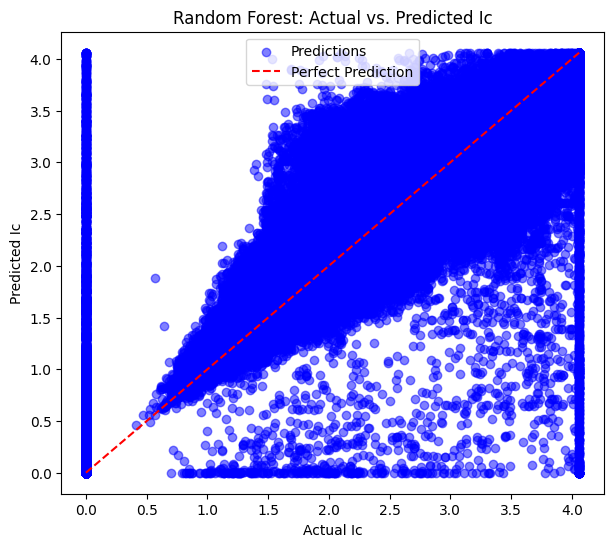

In [ ]:
# Predict on test set
y_pred = rf.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Ic')
plt.ylabel('Predicted Ic')
plt.title('Random Forest: Actual vs. Predicted Ic')
plt.legend()
plt.show()

In [ ]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate percentile errors
errors = np.abs(y_pred - y_test)
p50 = np.percentile(errors, 50)
p90 = np.percentile(errors, 90)
p95 = np.percentile(errors, 95)

print("Test Set Performance Metrics:")
print("="*40)
print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"\nError Percentiles:")
print(f"50th percentile (median): {p50:.4f}")
print(f"90th percentile: {p90:.4f}")
print(f"95th percentile: {p95:.4f}")

Test Set Performance Metrics:
MSE:  0.137035
RMSE: 0.3702
MAE:  0.2506
R²:   0.7886

Error Percentiles:
50th percentile (median): 0.1793
90th percentile: 0.5489
95th percentile: 0.6985


## 7. Predict Ic with New Data

Use the trained model to predict Ic for new or unseen data samples.

In [ ]:
# Example: Predict Ic for a new sample
new_sample = np.array([[2.5, 10]]) # Example values for qc (MPa) and fs (kPa)
new_sample_scaled = scaler.transform(new_sample)
predicted_Ic = rf.predict(new_sample_scaled)
print(f"Predicted Ic for new sample {new_sample}: {predicted_Ic[0]:.3f}")

Predicted Ic for new sample [[ 2.5 10. ]]: 2.127


/home/lug/miniconda3/envs/cpt-fm/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


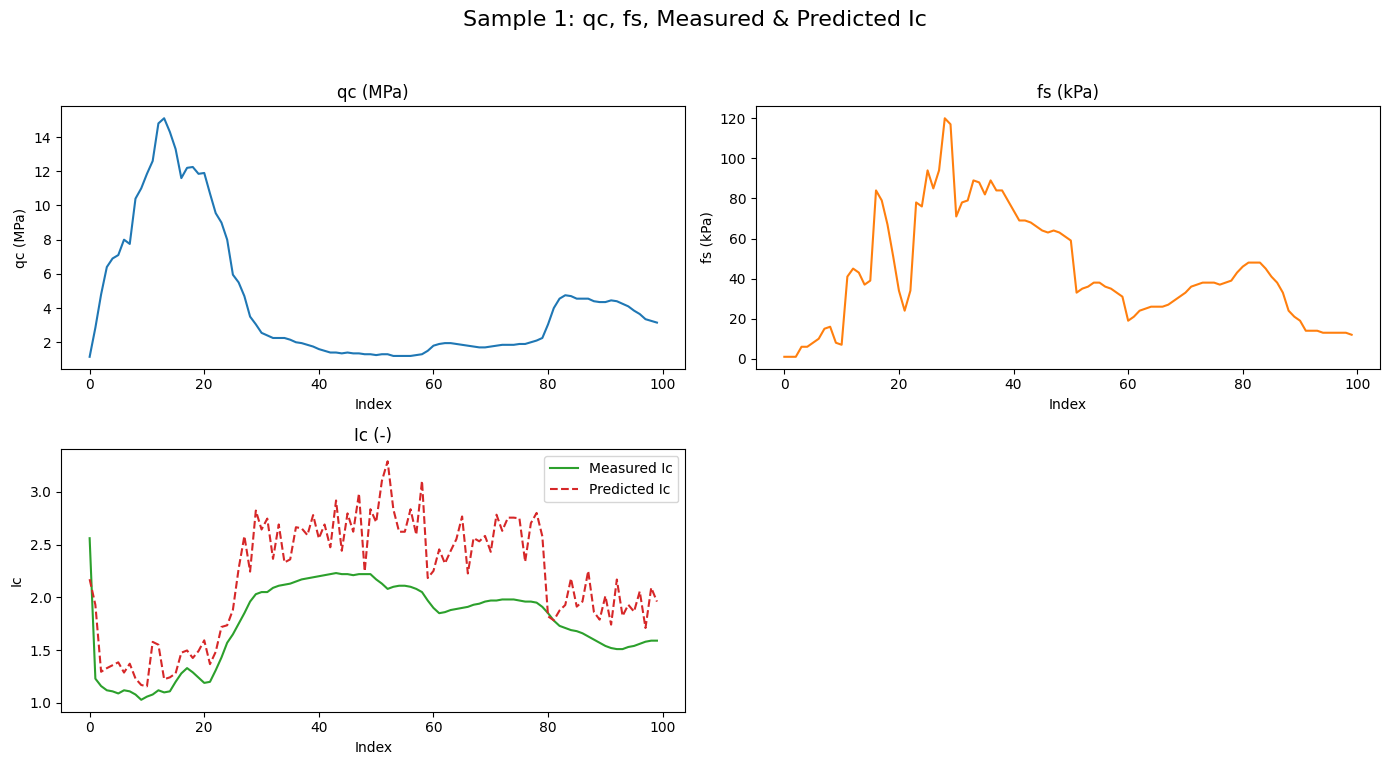

In [ ]:
# Visualize qc, fs, measured Ic, and predicted Ic for a few CPTs (separate figures for each CPT)
import matplotlib.gridspec as gridspec

# Assume CPTs are identified by a column, e.g., 'CPT_id'. If not, select random slices.
cpt_id_col = None
for col in df_clean.columns:
    if 'cpt' in col.lower():
        cpt_id_col = col
        break

if cpt_id_col:
    unique_cpts = df_clean[cpt_id_col].unique()
    selected_cpts = unique_cpts[:3]  # Show up to 3 CPTs
else:
    # If no CPT_id column, select 3 random slices of 100 points each
    selected_cpts = [None]

for idx, cpt in enumerate(selected_cpts):
    if cpt_id_col:
        cpt_mask = df_clean[cpt_id_col] == cpt
        df_cpt = df_clean[cpt_mask]
        X_cpt = scaler.transform(df_cpt[features])
        y_cpt = df_cpt[target].values
        y_pred_cpt = rf.predict(X_cpt)
        title = f'CPT {cpt}'
    else:
        # Random slice
        start = idx * 100
        end = start + 100
        df_cpt = df_clean.iloc[start:end]
        X_cpt = scaler.transform(df_cpt[features])
        y_cpt = df_cpt[target].values
        y_pred_cpt = rf.predict(X_cpt)
        title = f'Sample {idx+1}'

    fig = plt.figure(figsize=(14, 8))
    gs = gridspec.GridSpec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(df_cpt.index, df_cpt['qc (MPa)'], color='tab:blue')
    ax1.set_title('qc (MPa)')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('qc (MPa)')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(df_cpt.index, df_cpt['fs (kPa)'], color='tab:orange')
    ax2.set_title('fs (kPa)')
    ax2.set_xlabel('Index')
    ax2.set_ylabel('fs (kPa)')

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(df_cpt.index, y_cpt, color='tab:green', label='Measured Ic')
    ax3.plot(df_cpt.index, y_pred_cpt, color='tab:red', linestyle='--', label='Predicted Ic')
    ax3.set_title('Ic (-)')
    ax3.set_xlabel('Index')
    ax3.set_ylabel('Ic')
    ax3.legend()

    fig.suptitle(f'{title}: qc, fs, Measured & Predicted Ic', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()